# Project 1 - Probabilistic Programming - LDA

### 1. Import Libraries

In [389]:
# General use
import numpy as np
import pandas as pd
import random
from scipy.stats import norm
# For reading the files
import os
# For text preprocessing
import re
from nltk.stem import *
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
# Inferance
import pymc as pm
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pymc.Matplot import plot as mcplot


### 2. Import and read files

In [405]:
basepath = 'data_project/2_series_18_descriptions/'       # 18 files: 10 are Harry Potther movies descriptions
                                                          # 8 are Star Wars movies descriptions
data = np.chararray([])
K = 3                # number of topics

for entry in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, entry)):
        f = open(r"{}/{}".format(basepath, entry), "r")
        data = np.append(data, f.read())

# data

array(['\x01',
       "Harry, Ron, and Hermione search for Voldemort's remaining Horcruxes in their effort to destroy the Dark Lord as the final battle rages on at Hogwarts.\n",
       "Luke Skywalker joins forces with a Jedi Knight, a cocky pilot, a Wookiee and two droids to save the galaxy from the Empire's world-destroying battle station, while also attempting to rescue Princess Leia from the mysterious Darth Vader.\n",
       "Three decades after the Empire's defeat, a new threat arises in the militant First Order. Defected stormtrooper Finn and the scavenger Rey are caught up in the Resistance's search for the missing Luke Skywalker.\n",
       'As Harry Potter (Daniel Radcliffe) begins his sixth year at Hogwarts, he discovers an old book marked as "the property of the Half-Blood Prince" and begins to learn more about Lord Voldemort\'s (Ralph Fiennes\') dark past.\n',
       'Ten years after initially meeting, Anakin Skywalker shares a forbidden romance with Padm\xc3\xa9 Amidala, 

In [391]:
# other folders with files I can test on are:
# 2_series_18_descriptions      K=2-4   V=235
# 3_series_17_descriptions      K=3-5   V=209
# 8_series_28_descriptions      K=8-10  V=345
# 20_movies_descriptions        k=10   V=264
# 30_movies_descriptions        k=12   V=373

### 3. Process text from files

In [392]:
corpus = []
for i in range(1, len(data)):
    string = re.sub('[^a-zA-Z]', ' ', data[i])   # remove punctuation
    string = string.lower()                      # make take lowercase
    string = string.split()                      # split the words as elements
    ps = PorterStemmer()                         # remove the irrelevat words and stopwords 
                                                 # and take the roots of the words
    string = [ps.stem(word) for word in string if not word in stopwords.words('english')]
    string = [s for s in string if len(s) > 1]   # remove one letter words
    string = ' '.join(string)                    # we reverse the list into a string
    corpus.append(string)                        #append the string to corpus


### 4. Create Vocabulary

In [393]:
cv = CountVectorizer(max_features=1500)          # convert text documents to a matrix of token counts
cv.fit_transform(corpus)                         # usually used for bag-of-words
dict_words = pd.Series(cv.vocabulary_)           # now dict_words index is represented by all distinct words 
                                                 # and its value is an unique number between 0 and V

### 5. Create the observed W

In [394]:
W = []                                             # identity of all words in all documents
N_i = []                                           # store here lengths of all files
for s, idx in zip(corpus, range(0, len(corpus))):
    list_of_words = s.split()
    W.append([])
    N_i = np.append(N_i, int(len(list_of_words)))  # number of words per document
    for word, index in zip(list_of_words, range(0, len(list_of_words))):
        list_of_words[index] = dict_words[word]    # transform word in the number it has in dict_words
    W[idx] = list_of_words                         # append it to W


### 6. Set 

In [395]:
V = len(dict_words)  # number or distinct words

M = len(corpus)      # number of documents
N = sum(N_i)         # number of words in all documents

alpha = np.ones(K)   # hyperparameter of Dirichlet distribution theta
beta = np.ones(V)    # hyperparameter of Dirichlet distribution phi

### 7. Define Theta Distribution

Theta is the distribution of topics in a given document. 
So $theta[i]$ will be distribution of all topics over document i.

In [396]:
theta = np.array([], dtype=object)                        # theta will be an array of CompletedDirichet dist
dirTheta = np.array([])                                   # dirTheta will be an array of Dirichlet distributions

for document in range(0, M):                              # for all documents
    dirichlet = pm.Dirichlet(name='dirTheta_%d' % document, theta=alpha) # draw Dirichlet distribution with 
                                                                         # parameter alpha 
    dirTheta = np.append(dirTheta, dirichlet)
    theta = np.append(theta, pm.CompletedDirichlet("theta_%d" % document, dirichlet)) # create CompletedDirichlet
                                                                                      # with respect to dirichlet

### 8. Define Phi Distribtuion

Phi is the distribution of words in a given topic. 
So $phi[i]$ will be distribution of all words in vocabulary over topic $i$.
We use a CompletedDirichlet Distribution witch for any $k-1$ given variables computes the $k$ th variable as $1-sum$(of the other k-1 variables)


In [397]:
phi = np.array([], dtype=object)                        # phi will be an array of CompletedDirichlet distributions
dirPhi = np.array([])                                   # dirPhi will be an array of Dirichlet distributions

for topic in range(0, K):                               # for all topics
    dirichlet = pm.Dirichlet(name='dirPhi_%d' % topic, theta=beta)   # draw Dirichle distribution with 
                                                                     # parameter beta
    dirPhi = np.append(dirPhi, dirichlet)
    phi = np.append(phi, pm.CompletedDirichlet("phi_%d" % topic, dirichlet)) # create CopltedDirichlet with 
                                                                             # respect to dirichlet


### 9. Define Z Distribution

In [398]:
Z = []                                                  # Z will be an array of Categorical distributions
for doc in range(0, M):                                 # for all documents
    Z.append([])                                        # we create an array of Categorical variables with length
                                                        # N_i[doc] (i.e. length of file) 
    Z[doc] = pm.Categorical(name='Z_%d' % doc, p=theta[doc].value, size=int(N_i[doc]),  
                          value=np.random.randint(K, size=int(N_i[doc])))
Z = np.array(Z, dtype=object)


### 10. Define W Distribution

In [399]:
W_dist = np.array([], dtype=object)


for doc in range(0, M):                                       # for all documents
    for word in range(0, int(N_i[doc])):
        w = pm.Categorical(name='W_dist_%d_%d' % (doc, word), # create a Categorical variable
                           value=W[doc][word],                # observed value from documents
                           p=phi[Z[doc][word].value].value,   # phi value for Z value of doc d and word w
                           observed=True)
        W_dist = np.append(W_dist, w)


### 11. Model

In [400]:
model = pm.Model(
    [pm.ListContainer(dirPhi), pm.ListContainer(dirTheta), pm.Container(theta), pm.Container(phi), pm.Container(Z),
     pm.Container(W_dist)])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 39000, 1)


 [-----------------100%-----------------] 40000 of 40000 complete in 89.5 sec

### 12. Theta Visualization

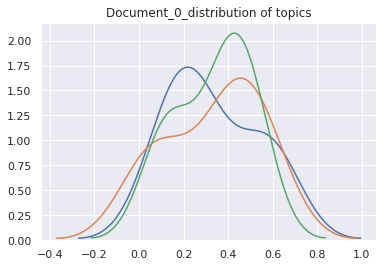

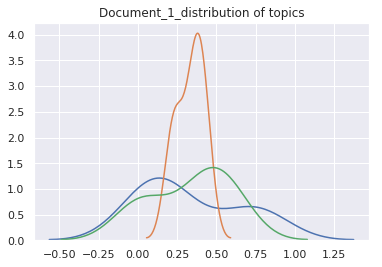

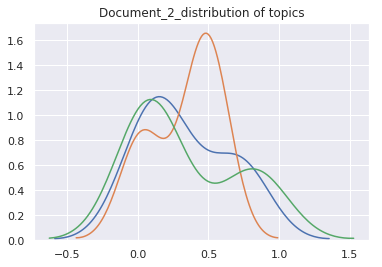

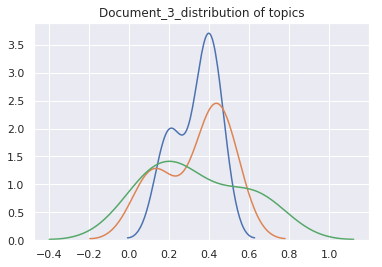

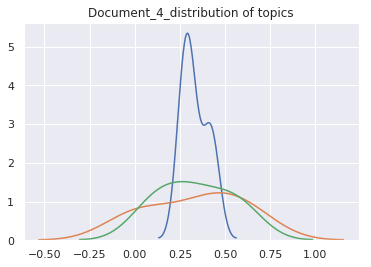

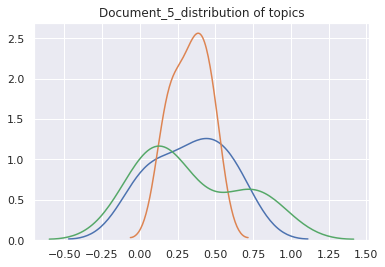

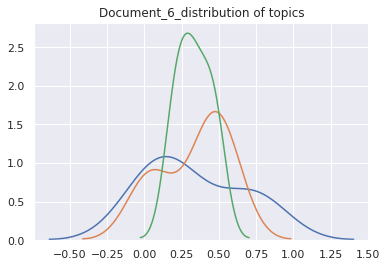

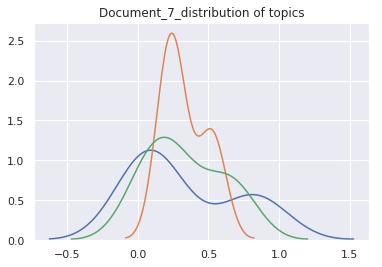

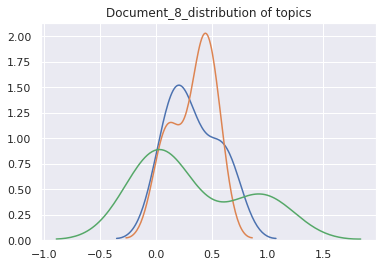

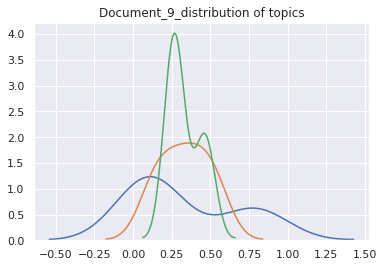

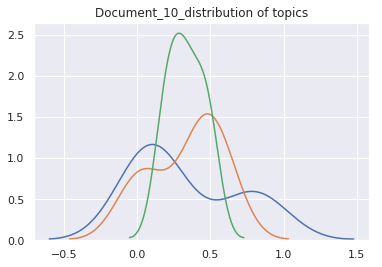

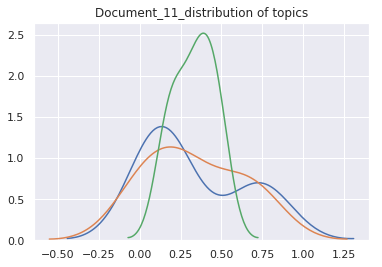

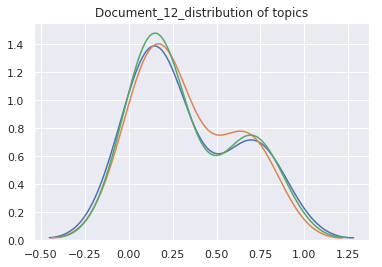

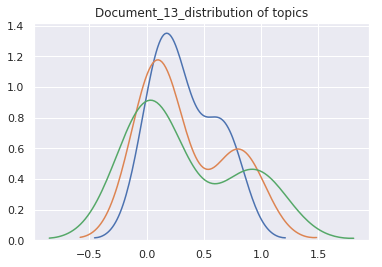

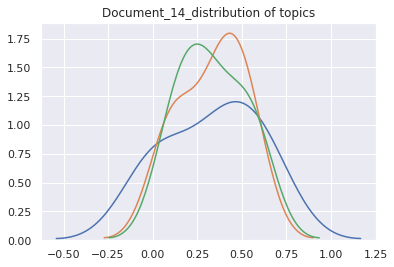

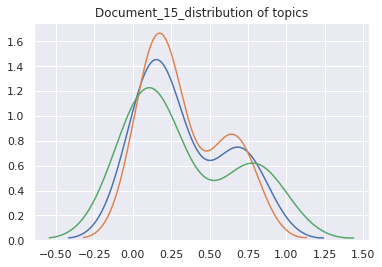

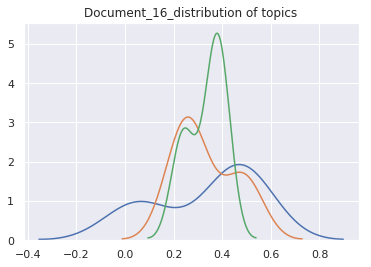

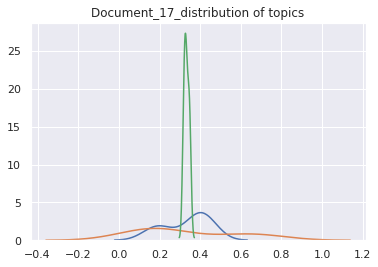

In [401]:

theta_samples = []


for doc in range(0, M):
    theta_samples.append([])
    t = mcmc.trace('theta_%d' % doc)[:]
    theta_samples[doc] = t
#     print np.array(t).shape
    for i in range(0, K):
        sns.distplot(t[:][:][i], norm_hist=True, hist=False)
        plt.title("Document_%d_distribution of topics" %doc)
    
    plt.show()


### 13. Phi Visualization

In [402]:

phi_samples = []
df = pd.DataFrame()

for topic in range(0, K):
    phi_samples.append([])
    p = mcmc.trace('phi_%d' % topic)[:]

    phi_samples[topic] = p
    most_used_words = np.argsort(p[-1][0])[:10]
    test = []
    for i in range(0, len(most_used_words)):
        test.append(str(dict_words[dict_words==most_used_words[i]].index.values)[3:-2])
    df['topic_%d' %topic] = test

print df


      topic_0        topic_1   topic_2
0        star          glori  adventur
1     dormant           fall     milit
2     terribl         gambon      half
3  tournament        develop    kenobi
4        join         effort   unsettl
5      kenobi          first    target
6    resurfac  magizoologist    knight
7        half          darth      meet
8       power           true    defeat
9        fall         secret    search


In one example I obtained this data for the most popular words in each topic. As you can see the first topic contains a majority of StarWars words while the second is more about Harry Potter and the third is mixed.


### 14. Z Visualization

0


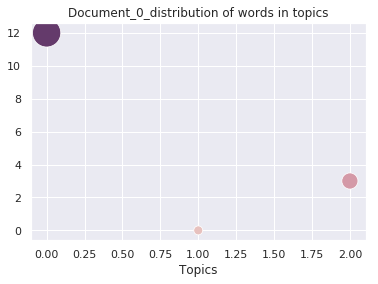

1


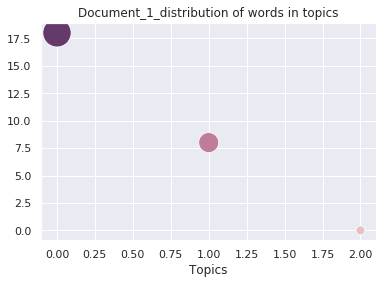

2


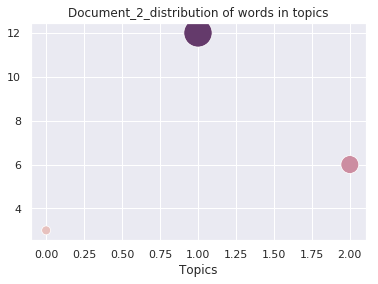

3


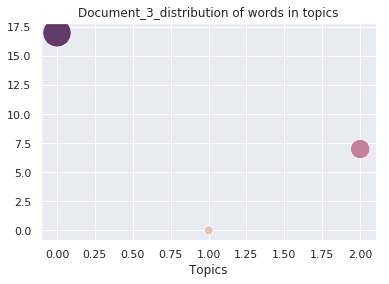

4


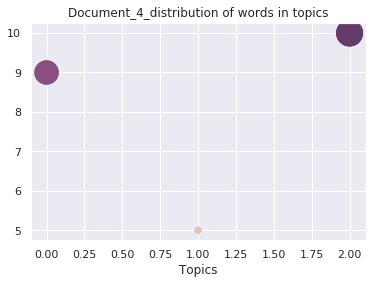

5


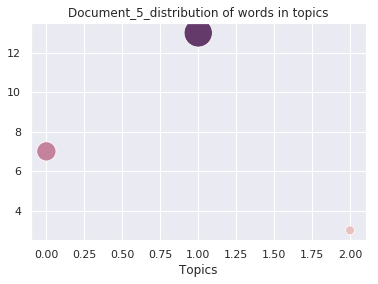

6


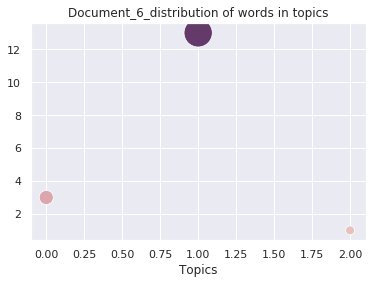

7


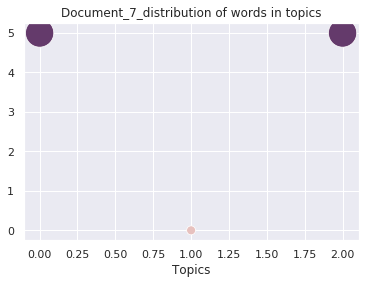

8


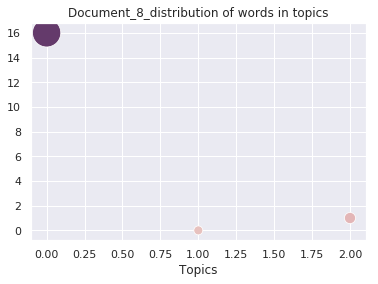

9


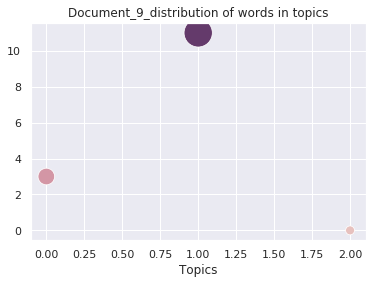

10


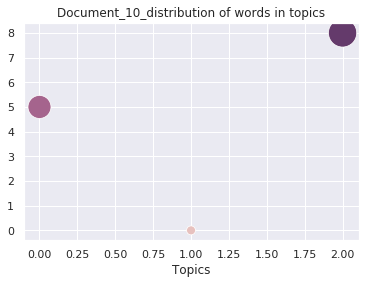

11


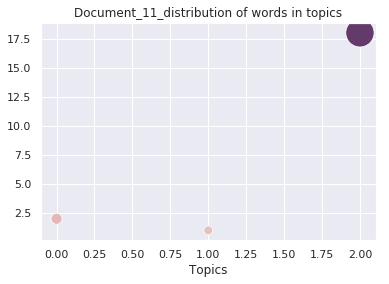

12


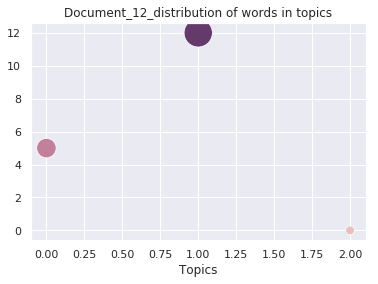

13


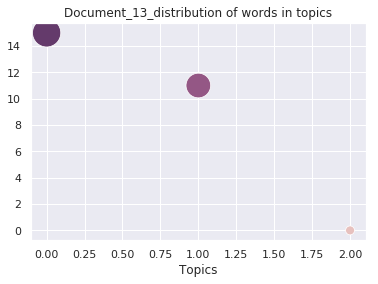

14


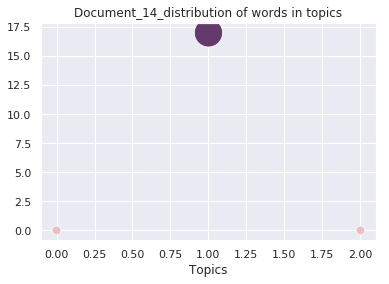

15


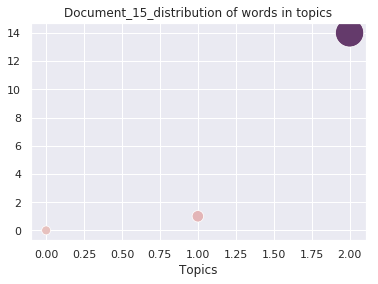

16


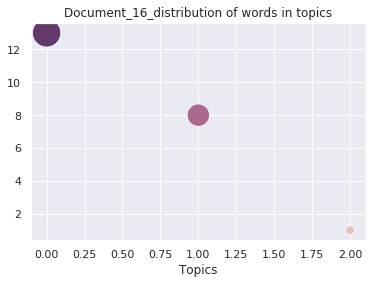

17


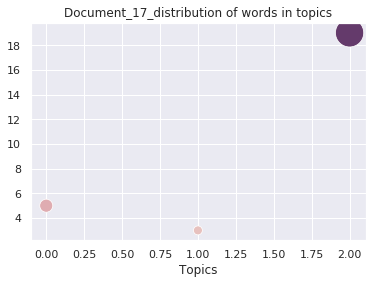

In [403]:
Z_samples = []

for doc in range(0, M):
    Z_samples.append([])
    z = mcmc.trace('Z_%d' % doc)[:]
    Z_samples[doc] = z
    mp = {i:0 for i in range(K)} 
    for i in range(0, len(z[-1][:])):
        mp[z[-1][:][i]] += 1
    mp = pd.Series(mp)
    cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
    sns.scatterplot(mp.index, mp.values, size=mp.values, sizes=(80, 800), legend=False, palette=cmap, hue=mp.values)
    print doc
    plt.title("Document_%d_distribution of words in topics" %doc)
    plt.xlabel("Topics")
#     plt.ylabel("y-label")
    plt.show()
# print Z_samples

### KL-divergence
for telling the difference between 2 documents


0.9157427309122603


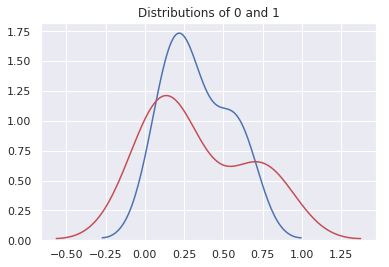

In [407]:
sns.set()

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))
print(kl_divergence(theta_samples[0][:][0], theta_samples[1][:][0]))
sns.distplot(theta_samples[0][:][0], color='b', hist=False, norm_hist=True)
sns.distplot(theta_samples[1][:][0], color='r', hist=False, norm_hist=True)
plt.title('Distributions of %d and %d' %(0, 1))
plt.show()